# Centrifugal Pump (CP)
March 9th, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [622]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import linregress
import math
import warnings
warnings.filterwarnings('ignore')

### Reading in Data from .csv

In [623]:
df = pd.read_csv("MW1-Centrifugal Pump Lab Raw Data - Sheet1.csv")

In [624]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN


### Pre-Processing

Converting our flow rate to a volumetric flow rate in m^3 / sec:

$$ \text{flow rate in } \frac{\text{gallon}}{\text{min}} = \frac{6.309 \times 10^-5 \text{cubic meters}}{\text{gallon}} \times \frac{\text{1 min}}{\text{60 sec}}$$

In [625]:
df["volumetric_flowrate"] = df["flow_rate"] * 6.309 * 10 ** -5 * (1 / 60) # m^3/s

converting inches to meters

$$ 39.37 \ \text{in} = 1 \ \text{m}$$

In [626]:
df["impeller_diam_meters"] = df["impeller_diam"] * (1/39.37)
df["inner_diam_meters"] = df["inner_diam"] * 0.01

converting psig to pascals
$$ psia = psig + 14.7 $$
$$ 1 \ psia = 6894.75728 \ \text{Pa}$$

In [627]:
df["pump_suction_pressure_pa"] = (df["pump_suction_pressure"] + 14.7) * 6894.75728
df["pump_discharge_pressure_pa"] = (df["pump_discharge_pressure"] + 14.7) * 6894.75728

In [628]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136


## Analysis Question 1
$$ \textbf {For one impeller, plot head versus capacity with rotational speed as a parameter (See
references for determining head and capacity.)} $$

We used two methods of computing head experimental, the first using the rotameter which currently sits in the dataframe, and the second using the expression below. We are more interested in the below because we believe it is a more accurate measure of head.

We can compute experimental head using the LHS of (Noel de Nevers, 373).

$$ H = \frac{P_4 - P_1}{\rho g} $$

In [629]:
g = 9.81 # m/s^2
rho = 997 # kg/m^3

In [630]:
df["head_exp"] = (df["pump_discharge_pressure_pa"] - df["pump_suction_pressure_pa"]) / (rho * g)
df["delta_head_exp"] = df["head_exp"] - df["head_exp"].shift(-1)

In [631]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633


Now let's plot this pump head against capacity which we know is the same as head-flowrate (McCabe-Smith, 202)

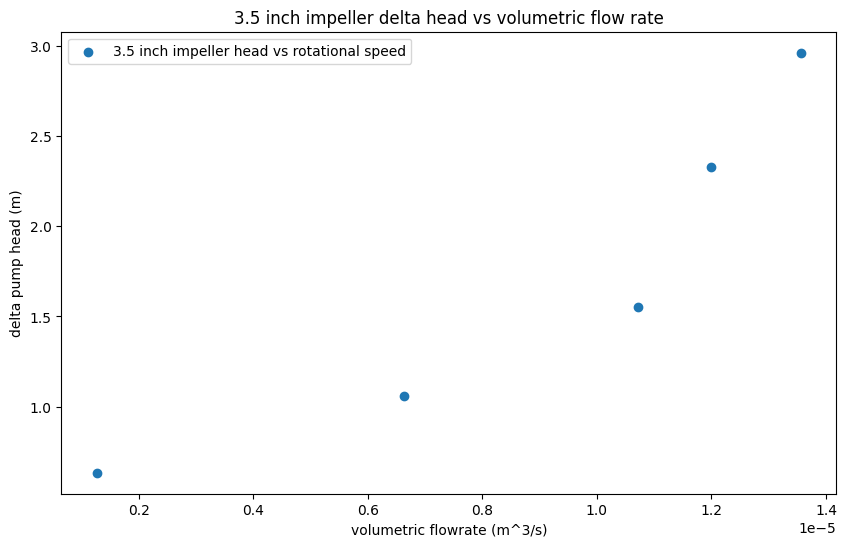

In [632]:
df_small = df.query("impeller_diam == 3.500")

plt.figure(figsize=(10,6))
plt.scatter(df_small["volumetric_flowrate"], df_small["head_exp"], marker="o", label="3.5 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("delta pump head (m)")
plt.title("3.5 inch impeller delta head vs volumetric flow rate")
plt.legend()

Let's plot the rest of the impeller sizes to ensure that this is the correct shape we should be looking for

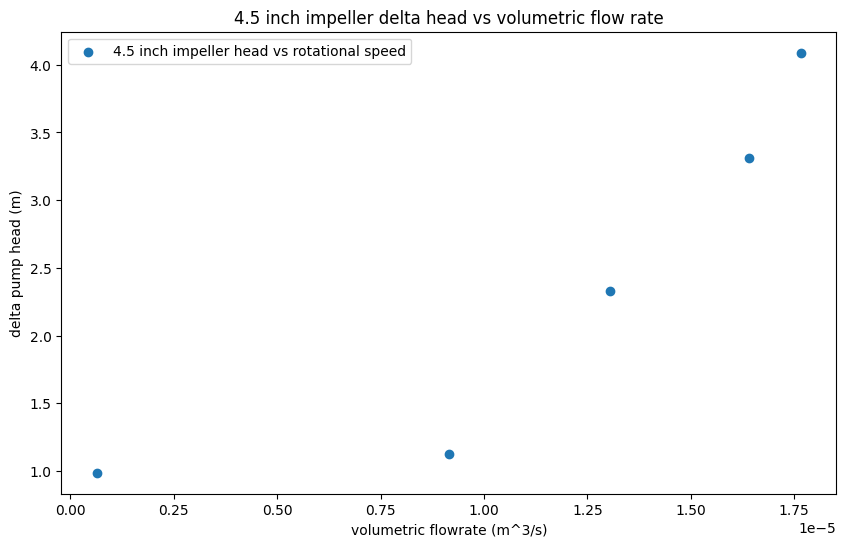

In [633]:
df_med = df.query("impeller_diam == 4.500")

plt.figure(figsize=(10,6))
plt.scatter(df_med["volumetric_flowrate"], df_med["head_exp"], marker="o", label="4.5 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("delta pump head (m)")
plt.title("4.5 inch impeller delta head vs volumetric flow rate")
plt.legend()

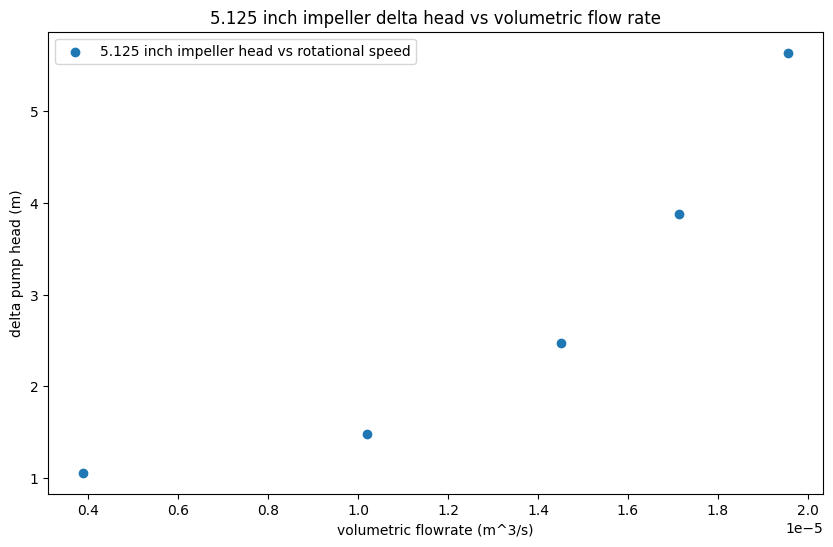

In [634]:
df_big = df.query("impeller_diam == 5.125")

plt.figure(figsize=(10,6))
plt.scatter(df_big["volumetric_flowrate"], df_big["head_exp"], marker="o", label="5.125 inch impeller head vs rotational speed")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("delta pump head (m)")
plt.title("5.125 inch impeller delta head vs volumetric flow rate")
plt.legend()

Now, we have a good sense of the shape, it is best reprsented by the 5.125 inch impeller so we will use this going forward. Let's synthesize a quantitative relationship that describes effect of rotational speed on head. The relationship appears polynomial, so we can fit a polynomial regression to this line. 

In [635]:
impeller_size = 5.125
subset = df[df["impeller_diam"] == impeller_size].copy()
subset.dropna(inplace=True)

X = subset[["volumetric_flowrate"]].values 
y = subset["head_exp"].values  

In [636]:
X_quad = np.hstack((X, X**2))

model = LinearRegression()
model.fit(X_quad, y)

b, c = model.coef_ 
d = model.intercept_ 

X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_quad = np.hstack((X_fit, X_fit**2))
y_fit = model.predict(X_fit_quad)


In [637]:
def quadratic(N, b, c, d):
    return b * N**2 + c * N + d

popt_quad, _ = curve_fit(quadratic, X.flatten(), y)
y_fit_scipy = quadratic(X_fit.flatten(), *popt_quad)

ADD ERROR BARS

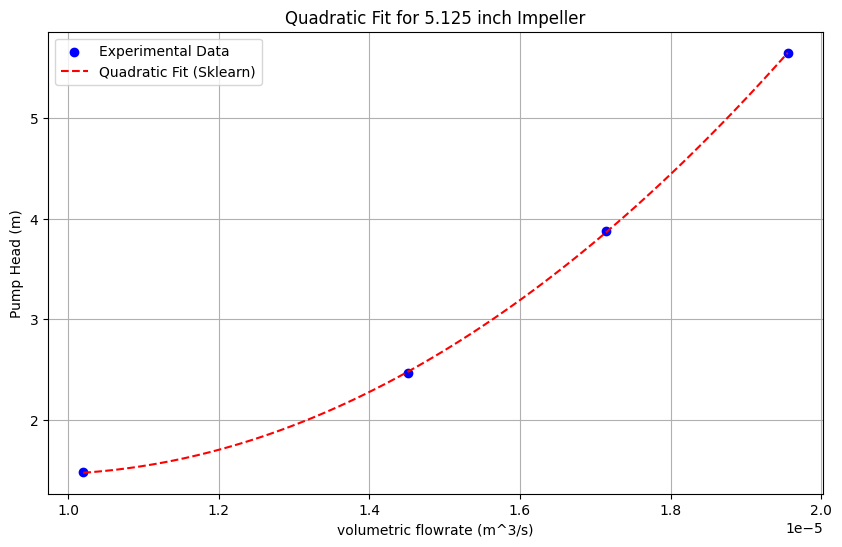

'Quadratic Fit: H = -8.099460e+05N² + 4.218565e+10N + 5.350265e+00'

In [638]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Experimental Data", color="blue")
plt.plot(X_fit, y_fit, label="Quadratic Fit (Sklearn)", color="red", linestyle="--")
plt.xlabel("volumetric flowrate (m^3/s)")
plt.ylabel("Pump Head (m)")
plt.title(f"Quadratic Fit for {impeller_size} inch Impeller")
plt.legend()
plt.grid(True)
plt.show()

quad_eq = f"Quadratic Fit: H = {b:.6e}N² + {c:.6e}N + {d:.6e}"
quad_eq

So, we can synthesize a head(fpm) expression of 

$$
h(fpm) = -8.099460e+05 fpm^{2} + 4.218565e+10 fpm + 4.5.350265
$$

We can also plot using a physical law like the head equation from (Noel de Nevers, 373) which we will denote as (1.1). Note that we will neglect as a necessary assumption. An additional assumption we make is the choice of velocities since we are restricted to inner an outter .

(1.1):
$$ H =  \frac{\omega ^ 2}{g} (r_3 ^ 2 - r_2 ^ 2) + \frac{V_2 ^ 2 - V_3 ^ 2}{2g}$$

This provides H as a function of angular velocity 

$$ H \approx f(\omega) $$

In [639]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633


## Analysis Question 2

$$ \textbf{Prepare a plot of head as a function of capacity for a single rpm.} $$

motor speed and RPM are analagous so we will partition our dataframe on each impeller diameter.

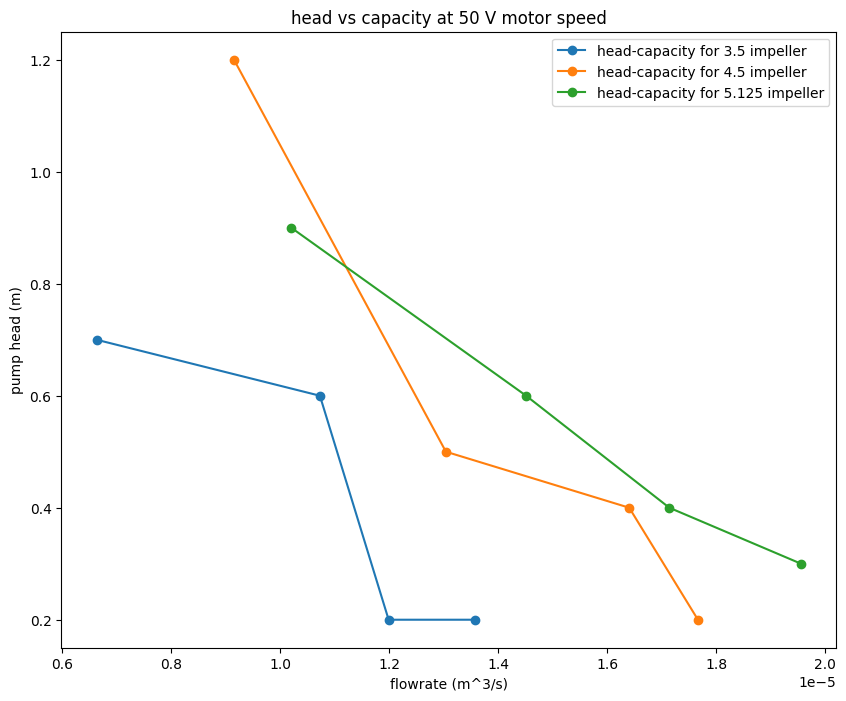

In [682]:
plt.figure(figsize=(10,8))
for diam in df["impeller_diam"].unique():
    df_diam = df.query("impeller_diam == @diam")
    plt.title("head vs capacity at 50 V motor speed")
    plt.plot(df_diam["volumetric_flowrate"][:4], df_diam["delta_head_exp_meas"][:4], marker="o", label = f"head-capacity for {diam} impeller")
    plt.legend()
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")

$$ \textbf{Describe qualitatively the effect of impeller diameter on the
head-capacity relationship.}$$

$$\textbf{Can you describe this relationship quantitatively?}
$$

This shows that as you increase diameter, the pump head increases but pump head and flow rate retain a negative relationship. To describe this quantitatively, we reference the below equation (2.1):

$$ H_{ideal} = \frac{\omega ^ 2}{g} (r_3^2 - r_2 ^2) + \frac{P_{suction}^2 - P_{discharge}^2}{2g}$$

So this is a quantitative relationship that describes head as a function of diameter and flow rate:

$$ H \propto (\frac{D}{2})^2$$

(Noel de Nevers, 373)

## Analysis Question 3
$$ \textbf{For the larger impeller at the highest speed, plot the
observed head versus}$$

$$ \textbf{capacity and the relationship predicted by the analysis of the
ideal pump} $$

We start by finding the ideal pump head-capacity relationship which is given by the equation at (Noel de Nevers, 373) but we will neglect friction and assume that radial and tangential velocity are equal.

(3.1):
$$ H_{ideal} = \frac{\omega ^ 2}{g} (r_3^2 - r_2 ^2) + \frac{V_1^2 - V_4^2}{2g} - \frac{F_{3-4} - F_{1-2}}{g}$$

But with our assumptions neglecting friction and assuming V_1 = V_4 for an ideal system:

$$ H_{ideal} = \frac{\omega ^ 2}{g} (r_3^2 - r_2 ^2)$$


In [641]:
df["angular_velocity_ext"] = df["ext_fpm"] * (2 * np.pi / 60)
df["angular_velocity_int"] = df["int_fpm"] * (2 * np.pi / 60)

In [689]:
df["head_ideal"] = (((df["angular_velocity_ext"] ** 2)/(g)) * ((df["impeller_diam_meters"]/2) ** 2 - (df["inner_diam_meters"]/2) ** 2))
df["delta_head_ideal"] = df["head_ideal"] - df["head_ideal"].shift(-1)

In [690]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,angular_velocity_int,head_ideal,delta_head_ideal,C,drive_shaft_torque_Nm,angular_velocity_rad_s,shaft_power_W,pressure_difference_Pa,hydraulic_power_W,pump_efficiency,flow_coefficient
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,81.482441,15.422675,5.626193,112819.166844,0.5650,5.235988,2.958333,28957.980576,0.392796,0.132776,6.042216e-08
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,81.482441,9.796482,4.413457,141555.802956,0.3616,4.188790,1.514667,22752.699024,0.272739,0.180065,6.674541e-08
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,81.482441,5.383025,3.094152,190963.137173,0.2260,3.141593,0.710000,15168.466016,0.162686,0.229136,7.962610e-08
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,81.482441,2.288873,1.797174,292854.466479,0.1130,2.094395,0.236667,10342.135920,0.068511,0.289483,7.377124e-08
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,81.482441,0.491700,-24.895961,631848.176714,0.1130,1.047198,0.118333,6205.281552,0.007830,0.066168,2.810333e-08
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722,69.889965,25.387661,8.607353,92113.478277,1.1865,5.235988,6.212499,39989.592224,0.706424,0.113710,3.702392e-08
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889,69.889965,16.780308,7.513832,113301.214399,0.7910,4.188790,3.313333,32405.359216,0.531558,0.160430,4.297419e-08
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510,69.889965,9.266476,5.444231,152467.484211,0.4520,3.141593,1.420000,22752.699024,0.296663,0.208918,4.554530e-08
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793,69.889965,3.822245,3.034933,237397.036498,0.2260,2.094395,0.473333,11031.611648,0.100918,0.213207,4.793275e-08
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297,69.889965,0.787312,-33.656672,523071.617113,0.1130,1.047198,0.118333,9652.660192,0.006090,0.051464,6.611414e-09


In [691]:
df_big = df.query("impeller_diam == 5.125")

Text(0, 0.5, 'pump head (m)')

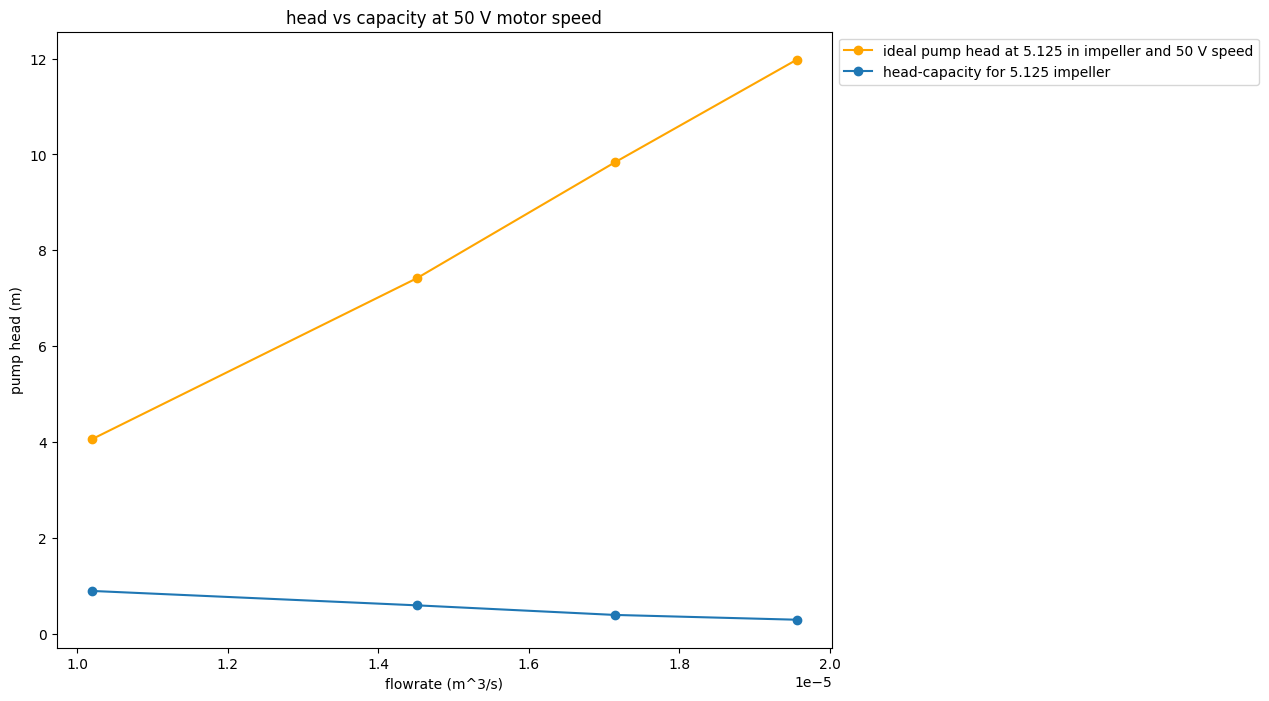

In [697]:
plt.figure(figsize=(10,8))
plt.plot(df_big["volumetric_flowrate"][:4], df_big["delta_head_ideal"][:4], label="ideal pump head at 5.125 in impeller and 50 V speed", color ="orange", marker="o")
plt.title("head vs capacity at 50 V motor speed")
plt.plot(df_diam["volumetric_flowrate"], df_diam["delta_head_exp_meas"], marker="o", label = f"head-capacity for {diam} impeller")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("flowrate (m^3/s)")
plt.ylabel("pump head (m)")

In [647]:
df_big = df.query("impeller_diam == 5.125")

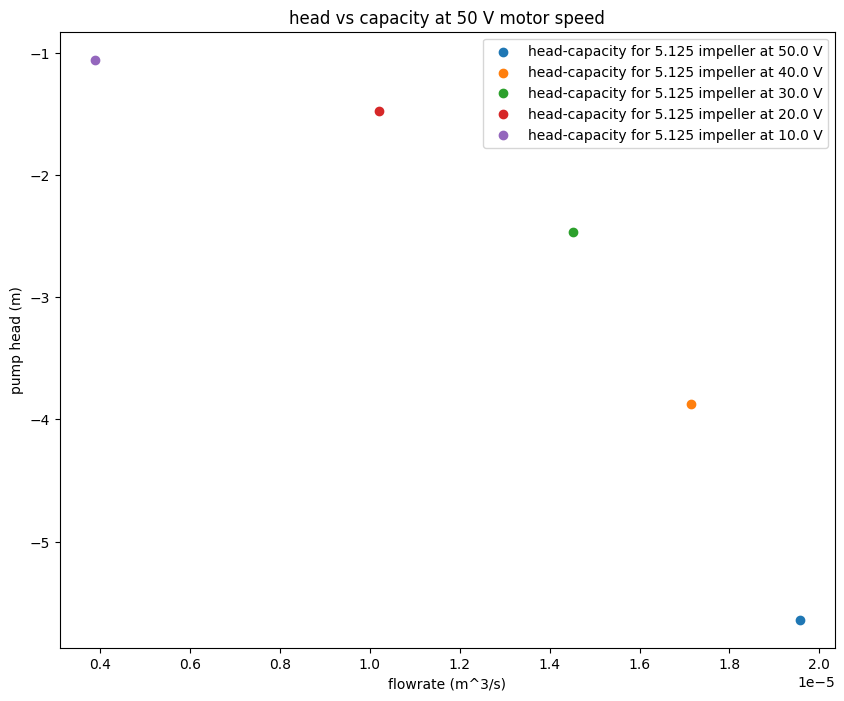

In [648]:
plt.figure(figsize=(10,8))
for speed in df["motor_speed"].unique():
    df_speed = df_big.query("motor_speed == @speed")
    plt.title("head vs capacity at 50 V motor speed")
    plt.scatter(df_speed["volumetric_flowrate"], -df_speed["head_exp"], marker="o", label = f"head-capacity for 5.125 impeller at {speed} V")
    plt.legend()
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")

## Analysis Question 4

$$ \textbf{For a single impeller size,
plot dimensionless head as a function of dimensionless flow for all speeds using the
non-dimensional groups of Streeter.} $$

From Streeter, we can see that the head coefficient is given by:
$$ \psi = \frac{gH}{\omega^2D^2} $$
and the dimensionless correlation for flow is given by:

$$ \phi = \frac{Q}{\omega D^3} $$


for H we will use the ideal H expression given as
$$ \Delta H_r = \frac{u_2(u_2-q_r/A_p tan \beta_2)}{g_c} $$

Let's add the angle data for each impeller from the lab manual

In [649]:
#impeller diameter has units of inches
#motor speed has units of volts
#ext fpm is rotations per minute
#field voltage has units of volts
#armature voltage has units of volts
#field current has units of miliAmperes
#armature current has units of amperes
#pump section pressure has units of psig
#pump discharge pressure has units of psig
#drive shaft torque has units of ft lbs
#flow rate has units of gallons per minute

sdf = df.iloc[:, :-3]
sdf

standard_df = sdf.copy()
standard_df['impeller_diam'] = standard_df['impeller_diam'] * 0.0254
standard_df['ext_fpm'] = standard_df['ext_fpm'] * 2 * np.pi / 60
standard_df['field_current'] = standard_df['field_current'] / 1000
standard_df['pump_suction_pressure'] = (standard_df['pump_suction_pressure'] + 14) * 6894.76
standard_df['pump_discharge_pressure'] = (standard_df['pump_discharge_pressure'] + 14) * 6894.76
standard_df['drive_shaft_torque'] = standard_df['drive_shaft_torque'] * 1.355818
standard_df['flow_rate'] = standard_df['flow_rate'] * 0.003785411784 / 60
standard_df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext
0,1.00,3.71,0.4,0.088900,50.0,304.504104,778.1,139,134,0.280,2.2,105489.828,134447.820,6.779090,21.5,0.000814,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104
1,1.00,3.71,0.4,0.088900,40.0,242.688032,778.1,139,107,0.280,1.9,108247.732,131000.440,4.338618,19.0,0.000719,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032
2,1.00,3.71,0.4,0.088900,30.0,179.898067,778.1,139,81,0.280,1.4,111005.636,126174.108,2.711636,17.0,0.000644,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067
3,1.00,3.71,0.4,0.088900,20.0,117.307070,778.1,138,54,0.280,1.1,113763.540,124105.680,1.355818,10.5,0.000397,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070
4,1.00,3.71,0.4,0.088900,10.0,54.370497,778.1,138,22,0.280,0.8,114453.016,120658.300,1.355818,2.0,0.000076,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497
5,1.00,3.50,0.5,0.114300,50.0,290.073722,667.4,140,130,0.300,3.6,103421.400,143411.008,14.236089,28.0,0.001060,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722
6,1.00,3.50,0.5,0.114300,40.0,235.828889,667.4,140,105,0.290,2.6,104110.876,136516.248,9.490726,26.0,0.000984,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889
7,1.00,3.50,0.5,0.114300,30.0,175.248510,667.4,140,80,0.290,1.9,108247.732,131000.440,5.423272,20.8,0.000782,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510
8,1.00,3.50,0.5,0.114300,20.0,112.552793,667.4,140,50,0.285,1.3,113074.064,124105.680,2.711636,14.5,0.000549,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793
9,1.00,3.50,0.5,0.114300,10.0,51.082297,667.4,140,25,0.285,1.0,114453.016,124105.680,1.355818,1.0,0.000038,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297


In [650]:
data = {
    'impeller_diameter_inches': [3.5, 4.5, 5.125],  # Diameters in inches
    'impeller_width_cm': [0.4, 0.5, 0.5],  # Widths in cm
    'beta_degrees': [17, 20, 19],  # Beta angles in degrees
    'impeller_thickness': [0.01, 0.01, 0.0089]  # Thickness in meters
}

# Create the Pandas DataFrame
dims = pd.DataFrame(data)

# Convert inches to meters
dims['impeller_diameter_meters'] = dims['impeller_diameter_inches'] * 0.0254

# Convert cm to meters
dims['impeller_width_meters'] = dims['impeller_width_cm'] * 0.01

# Convert degrees to radians
dims['beta_radians'] = np.radians(dims['beta_degrees'])

dims = dims.iloc[:, 3:]
dims

,impeller_thickness,impeller_diameter_meters,impeller_width_meters,beta_radians
0,0.0100,0.088900,0.004,0.296706
1,0.0100,0.114300,0.005,0.349066
2,0.0089,0.130175,0.005,0.331613


In [651]:
def head_coefficient(g, H, omega, D):
    return (g * H) / (omega**2 * D**2)

def flow_coefficient(Q, omega, D):
    return Q / (omega * D**3)

def Delta_H(u_2, q_r, A_p, beta_2, g_c):
    return (u_2*(u_2 - (q_r/A_p) * np.tan(beta_2)))/(g_c)

def Peripheral_Area(D, width):
    return np.pi * D * width

In [652]:
g_c = 9.81 #m/s^2
dims['A_p'] = Peripheral_Area(dims['impeller_diameter_meters'],dims['impeller_width_meters'])

combined_df = pd.merge(standard_df, dims, how='inner', on=None, left_on='impeller_diam', right_on='impeller_diameter_meters')
combined_df

combined_df['u_2'] = (combined_df['impeller_diameter_meters'] / 2) * combined_df['ext_fpm']
combined_df['Delta_H'] = Delta_H(combined_df['u_2'],combined_df['flow_rate'],combined_df['A_p'],combined_df['beta_radians'],g_c)
combined_df['flow_coefficient'] = flow_coefficient(combined_df['flow_rate'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df['head_coefficient'] = head_coefficient(g_c, combined_df['Delta_H'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df

,impeller_thickness_x,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,impeller_thickness_y,impeller_diameter_meters,impeller_width_meters,beta_radians,A_p,u_2,Delta_H,flow_coefficient,head_coefficient
0,1.00,3.71,0.4,0.088900,50.0,304.504104,778.1,139,134,0.280,2.2,105489.828,134447.820,6.779090,21.5,0.000814,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,0.0100,0.088900,0.004,0.296706,0.001117,13.535207,18.367700,0.003804,0.245886
1,1.00,3.71,0.4,0.088900,40.0,242.688032,778.1,139,107,0.280,1.9,108247.732,131000.440,4.338618,19.0,0.000719,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,0.0100,0.088900,0.004,0.296706,0.001117,10.787483,11.645920,0.004218,0.245438
2,1.00,3.71,0.4,0.088900,30.0,179.898067,778.1,139,81,0.280,1.4,111005.636,126174.108,2.711636,17.0,0.000644,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,0.0100,0.088900,0.004,0.296706,0.001117,7.996469,6.374642,0.005091,0.244494
3,1.00,3.71,0.4,0.088900,20.0,117.307070,778.1,138,54,0.280,1.1,113763.540,124105.680,1.355818,10.5,0.000397,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,0.0100,0.088900,0.004,0.296706,0.001117,5.214299,2.713734,0.004823,0.244785
4,1.00,3.71,0.4,0.088900,10.0,54.370497,778.1,138,22,0.280,0.8,114453.016,120658.300,1.355818,2.0,0.000076,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,0.0100,0.088900,0.004,0.296706,0.001117,2.416769,0.590285,0.001982,0.247857
5,1.00,3.50,0.5,0.114300,50.0,290.073722,667.4,140,130,0.300,3.6,103421.400,143411.008,14.236089,28.0,0.001060,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722,0.0100,0.114300,0.005,0.349066,0.001795,16.577713,27.651229,0.002447,0.246760
6,1.00,3.50,0.5,0.114300,40.0,235.828889,667.4,140,105,0.290,2.6,104110.876,136516.248,9.490726,26.0,0.000984,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889,0.0100,0.114300,0.005,0.349066,0.001795,13.477621,18.242326,0.002795,0.246299
7,1.00,3.50,0.5,0.114300,30.0,175.248510,667.4,140,80,0.290,1.9,108247.732,131000.440,5.423272,20.8,0.000782,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510,0.0100,0.114300,0.005,0.349066,0.001795,10.015452,10.063293,0.002989,0.246041
8,1.00,3.50,0.5,0.114300,20.0,112.552793,667.4,140,50,0.285,1.3,113074.064,124105.680,2.711636,14.5,0.000549,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793,0.0100,0.114300,0.005,0.349066,0.001795,6.432392,4.144743,0.003266,0.245675
9,1.00,3.50,0.5,0.114300,10.0,51.082297,667.4,140,25,0.285,1.0,114453.016,124105.680,1.355818,1.0,0.000038,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297,0.0100,0.114300,0.005,0.349066,0.001795,2.919353,0.866485,0.000496,0.249343


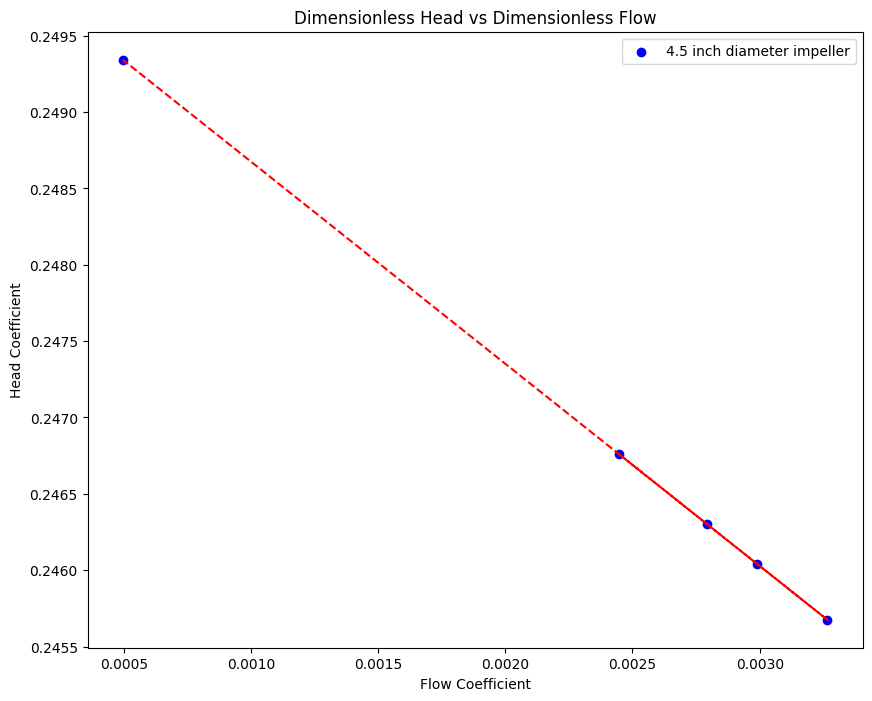

In [653]:
plt.figure(figsize=(10, 8))
plt.scatter(combined_df['flow_coefficient'][5:10], combined_df['head_coefficient'][5:10], label='4.5 inch diameter impeller', color='blue')
plt.plot(combined_df['flow_coefficient'][5:10], combined_df['head_coefficient'][5:10], color='red', linestyle="--")
plt.title("Dimensionless Head vs Dimensionless Flow")
plt.xlabel("Flow Coefficient")
plt.ylabel("Head Coefficient")
plt.legend()

plt.show()

## Analysis Question 5
$$ \textbf{For each speed, prepare a plot of dimensionless head as a function of dimensionless
capacity for different impeller sizes.} $$

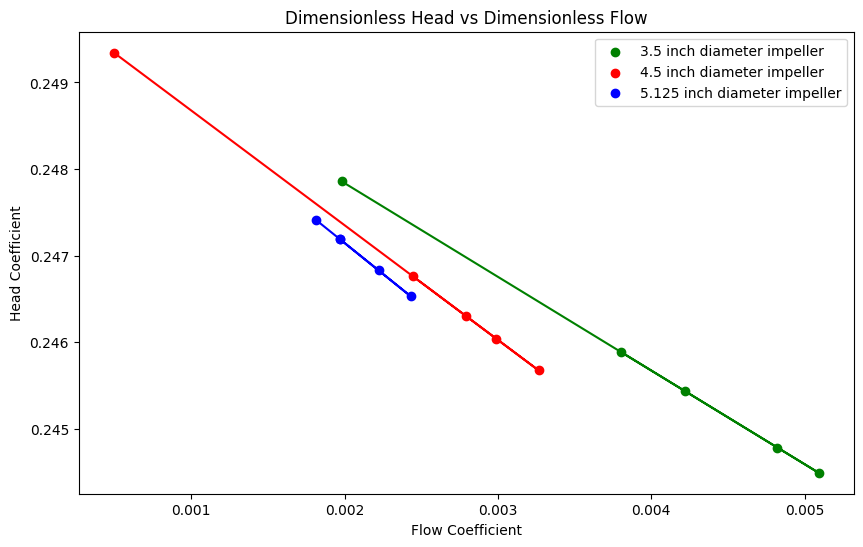

In [654]:
plt.figure(figsize=(10,6))
plt.scatter(combined_df['flow_coefficient'][:5], combined_df['head_coefficient'][:5], label='3.5 inch diameter impeller', color='green')
plt.scatter(combined_df['flow_coefficient'][5:10], combined_df['head_coefficient'][5:10], label='4.5 inch diameter impeller', color='red')
plt.scatter(combined_df['flow_coefficient'][10:15], combined_df['head_coefficient'][10:15], label='5.125 inch diameter impeller', color='blue')
plt.plot(combined_df['flow_coefficient'][:5], combined_df['head_coefficient'][:5], color='green')
plt.plot(combined_df['flow_coefficient'][5:10], combined_df['head_coefficient'][5:10], color='red')
plt.plot(combined_df['flow_coefficient'][10:15], combined_df['head_coefficient'][10:15], color='blue')

plt.title("Dimensionless Head vs Dimensionless Flow")
plt.xlabel("Flow Coefficient")
plt.ylabel("Head Coefficient")
plt.legend()

plt.show()

$$ \textbf{Identify data
points on this plot by the impeller size for which they were taken.}$$
$$ \textbf{Do you see three
distinct curves, one for each impeller? Is there a consistent effect of impeller diameter?}$$

The plot shows three distinct curves, each representing a different impeller size (3.5 inches, 4.5 inches, and 5.125 inches). All three curves show a negative correlation between the head coefficient and the flow coefficient. This means that as the flow coefficient increases, the head coefficient decreases for all impeller sizes. The 3.5-inch impeller (green) has the highest head coefficients for a given flow coefficient, followed by the 4.5-inch (red) and the 5.125-inch (blue) impellers. This suggests that smaller impellers generate higher head coefficients at the same flow coefficient. The trend is consistent across all impeller sizes, indicating that the effect of impeller diameter on the head-capacity relationship is systematic. Smaller impellers tend to produce higher head coefficients, while larger impellers produce lower head coefficients for the same flow coefficient.

### Using alternative characteristics lengths
Let us consider using impeller thickness as the characteristic length for the dimensionless groups.

In [655]:
#impeller diameter has units of inches
#motor speed has units of volts
#ext fpm is rotations per minute
#field voltage has units of volts
#armature voltage has units of volts
#field current has units of miliAmperes
#armature current has units of amperes
#pump section pressure has units of psig
#pump discharge pressure has units of psig
#drive shaft torque has units of ft lbs
#flow rate has units of gallons per minute

sdf = df.iloc[:, :-3]
sdf

standard_df = sdf.copy()
standard_df['impeller_diam'] = standard_df['impeller_diam'] * 0.0254
standard_df['ext_fpm'] = standard_df['ext_fpm'] * 2 * np.pi / 60
standard_df['field_current'] = standard_df['field_current'] / 1000
standard_df['pump_suction_pressure'] = (standard_df['pump_suction_pressure'] + 14) * 6894.76
standard_df['pump_discharge_pressure'] = (standard_df['pump_discharge_pressure'] + 14) * 6894.76
standard_df['drive_shaft_torque'] = standard_df['drive_shaft_torque'] * 1.355818
standard_df['flow_rate'] = standard_df['flow_rate'] * 0.003785411784 / 60
standard_df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext
0,1.00,3.71,0.4,0.088900,50.0,304.504104,778.1,139,134,0.280,2.2,105489.828,134447.820,6.779090,21.5,0.000814,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104
1,1.00,3.71,0.4,0.088900,40.0,242.688032,778.1,139,107,0.280,1.9,108247.732,131000.440,4.338618,19.0,0.000719,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032
2,1.00,3.71,0.4,0.088900,30.0,179.898067,778.1,139,81,0.280,1.4,111005.636,126174.108,2.711636,17.0,0.000644,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067
3,1.00,3.71,0.4,0.088900,20.0,117.307070,778.1,138,54,0.280,1.1,113763.540,124105.680,1.355818,10.5,0.000397,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070
4,1.00,3.71,0.4,0.088900,10.0,54.370497,778.1,138,22,0.280,0.8,114453.016,120658.300,1.355818,2.0,0.000076,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497
5,1.00,3.50,0.5,0.114300,50.0,290.073722,667.4,140,130,0.300,3.6,103421.400,143411.008,14.236089,28.0,0.001060,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722
6,1.00,3.50,0.5,0.114300,40.0,235.828889,667.4,140,105,0.290,2.6,104110.876,136516.248,9.490726,26.0,0.000984,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889
7,1.00,3.50,0.5,0.114300,30.0,175.248510,667.4,140,80,0.290,1.9,108247.732,131000.440,5.423272,20.8,0.000782,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510
8,1.00,3.50,0.5,0.114300,20.0,112.552793,667.4,140,50,0.285,1.3,113074.064,124105.680,2.711636,14.5,0.000549,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793
9,1.00,3.50,0.5,0.114300,10.0,51.082297,667.4,140,25,0.285,1.0,114453.016,124105.680,1.355818,1.0,0.000038,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297


In [656]:
data = {
    'impeller_diameter_inches': [3.5, 4.5, 5.125],  # Diameters in inches
    'impeller_width_cm': [0.4, 0.5, 0.5],  # Widths in cm
    'beta_degrees': [17, 20, 19],  # Beta angles in degrees
    'impeller_thickness': [0.01, 0.01, 0.0089]  # Thickness in meters
}

# Create the Pandas DataFrame
dims = pd.DataFrame(data)

# Convert inches to meters
dims['impeller_diameter_meters'] = dims['impeller_diameter_inches'] * 0.0254

# Convert cm to meters
dims['impeller_width_meters'] = dims['impeller_width_cm'] * 0.01

# Convert degrees to radians
dims['beta_radians'] = np.radians(dims['beta_degrees'])

dims = dims.iloc[:, 3:]
dims

,impeller_thickness,impeller_diameter_meters,impeller_width_meters,beta_radians
0,0.0100,0.088900,0.004,0.296706
1,0.0100,0.114300,0.005,0.349066
2,0.0089,0.130175,0.005,0.331613


In [657]:
def head_coefficient(g, H, omega, D):
    return (g * H) / (omega**2 * D**2)

def flow_coefficient(Q, omega, D):
    return Q / (omega * D**3)

def Delta_H(u_2, q_r, A_p, beta_2, g_c):
    return (u_2*(u_2 - (q_r/A_p) * np.tan(beta_2)))/(g_c)

def Peripheral_Area(D, width):
    return np.pi * D * width

In [658]:
g_c = 9.81 #m/s^2
dims['A_p'] = Peripheral_Area(dims['impeller_diameter_meters'],dims['impeller_width_meters'])

combined_df = pd.merge(standard_df, dims, how='inner', on=None, left_on='impeller_diam', right_on='impeller_diameter_meters')
combined_df

combined_df['u_2'] = (combined_df['impeller_diameter_meters'] / 2) * combined_df['ext_fpm']
combined_df['Delta_H'] = Delta_H(combined_df['u_2'],combined_df['flow_rate'],combined_df['A_p'],combined_df['beta_radians'],g_c)
combined_df['flow_coefficient'] = flow_coefficient(combined_df['flow_rate'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df['head_coefficient'] = head_coefficient(g_c, combined_df['Delta_H'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df

,impeller_thickness_x,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,impeller_thickness_y,impeller_diameter_meters,impeller_width_meters,beta_radians,A_p,u_2,Delta_H,flow_coefficient,head_coefficient
0,1.00,3.71,0.4,0.088900,50.0,304.504104,778.1,139,134,0.280,2.2,105489.828,134447.820,6.779090,21.5,0.000814,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,0.0100,0.088900,0.004,0.296706,0.001117,13.535207,18.367700,0.003804,0.245886
1,1.00,3.71,0.4,0.088900,40.0,242.688032,778.1,139,107,0.280,1.9,108247.732,131000.440,4.338618,19.0,0.000719,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,0.0100,0.088900,0.004,0.296706,0.001117,10.787483,11.645920,0.004218,0.245438
2,1.00,3.71,0.4,0.088900,30.0,179.898067,778.1,139,81,0.280,1.4,111005.636,126174.108,2.711636,17.0,0.000644,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,0.0100,0.088900,0.004,0.296706,0.001117,7.996469,6.374642,0.005091,0.244494
3,1.00,3.71,0.4,0.088900,20.0,117.307070,778.1,138,54,0.280,1.1,113763.540,124105.680,1.355818,10.5,0.000397,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,0.0100,0.088900,0.004,0.296706,0.001117,5.214299,2.713734,0.004823,0.244785
4,1.00,3.71,0.4,0.088900,10.0,54.370497,778.1,138,22,0.280,0.8,114453.016,120658.300,1.355818,2.0,0.000076,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,0.0100,0.088900,0.004,0.296706,0.001117,2.416769,0.590285,0.001982,0.247857
5,1.00,3.50,0.5,0.114300,50.0,290.073722,667.4,140,130,0.300,3.6,103421.400,143411.008,14.236089,28.0,0.001060,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722,0.0100,0.114300,0.005,0.349066,0.001795,16.577713,27.651229,0.002447,0.246760
6,1.00,3.50,0.5,0.114300,40.0,235.828889,667.4,140,105,0.290,2.6,104110.876,136516.248,9.490726,26.0,0.000984,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889,0.0100,0.114300,0.005,0.349066,0.001795,13.477621,18.242326,0.002795,0.246299
7,1.00,3.50,0.5,0.114300,30.0,175.248510,667.4,140,80,0.290,1.9,108247.732,131000.440,5.423272,20.8,0.000782,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510,0.0100,0.114300,0.005,0.349066,0.001795,10.015452,10.063293,0.002989,0.246041
8,1.00,3.50,0.5,0.114300,20.0,112.552793,667.4,140,50,0.285,1.3,113074.064,124105.680,2.711636,14.5,0.000549,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793,0.0100,0.114300,0.005,0.349066,0.001795,6.432392,4.144743,0.003266,0.245675
9,1.00,3.50,0.5,0.114300,10.0,51.082297,667.4,140,25,0.285,1.0,114453.016,124105.680,1.355818,1.0,0.000038,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297,0.0100,0.114300,0.005,0.349066,0.001795,2.919353,0.866485,0.000496,0.249343


In [659]:
g_c = 9.81 #m/s^2
dims['A_p'] = Peripheral_Area(dims['impeller_diameter_meters'],dims['impeller_width_meters'])

combined_df = pd.merge(standard_df, dims, how='inner', on=None, left_on='impeller_diam', right_on='impeller_diameter_meters')
combined_df

combined_df['u_2'] = (combined_df['impeller_diameter_meters'] / 2) * combined_df['ext_fpm']
combined_df['Delta_H'] = Delta_H(combined_df['u_2'],combined_df['flow_rate'],combined_df['A_p'],combined_df['beta_radians'],g_c)
combined_df['flow_coefficient'] = flow_coefficient(combined_df['flow_rate'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df['head_coefficient'] = head_coefficient(g_c, combined_df['Delta_H'], combined_df['ext_fpm'], combined_df['impeller_diameter_meters'])
combined_df = combined_df.rename(columns={"impeller_thickness_y": "impeller_thickness"})

In [660]:
combined_df['head_coefficient_alt'] = head_coefficient(g_c, combined_df['Delta_H'], combined_df['ext_fpm'], combined_df['impeller_thickness'])
combined_df['flow_coefficient_alt'] = flow_coefficient(combined_df['flow_rate'], combined_df['ext_fpm'], combined_df['impeller_thickness'])
combined_df.head()

,impeller_thickness_x,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,impeller_thickness,impeller_diameter_meters,impeller_width_meters,beta_radians,A_p,u_2,Delta_H,flow_coefficient,head_coefficient,head_coefficient_alt,flow_coefficient_alt
0,1.0,3.71,0.4,0.0889,50.0,304.504104,778.1,139,134,0.28,2.2,105489.828,134447.820,6.779090,21.5,0.000814,1.8,0.2,0.000014,0.0889,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,0.01,0.0889,0.004,0.296706,0.001117,13.535207,18.367700,0.003804,0.245886,19.432895,2.672751
1,1.0,3.71,0.4,0.0889,40.0,242.688032,778.1,139,107,0.28,1.9,108247.732,131000.440,4.338618,19.0,0.000719,1.6,0.2,0.000012,0.0889,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,0.01,0.0889,0.004,0.296706,0.001117,10.787483,11.645920,0.004218,0.245438,19.397515,2.963592
2,1.0,3.71,0.4,0.0889,30.0,179.898067,778.1,139,81,0.28,1.4,111005.636,126174.108,2.711636,17.0,0.000644,1.5,0.6,0.000011,0.0889,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,0.01,0.0889,0.004,0.296706,0.001117,7.996469,6.374642,0.005091,0.244494,19.322879,3.577137
3,1.0,3.71,0.4,0.0889,20.0,117.307070,778.1,138,54,0.28,1.1,113763.540,124105.680,1.355818,10.5,0.000397,0.9,0.7,0.000007,0.0889,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,0.01,0.0889,0.004,0.296706,0.001117,5.214299,2.713734,0.004823,0.244785,19.345854,3.388272
4,1.0,3.71,0.4,0.0889,10.0,54.370497,778.1,138,22,0.28,0.8,114453.016,120658.300,1.355818,2.0,0.000076,0.2,NaN,0.000001,0.0889,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,0.01,0.0889,0.004,0.296706,0.001117,2.416769,0.590285,0.001982,0.247857,19.588638,1.392451


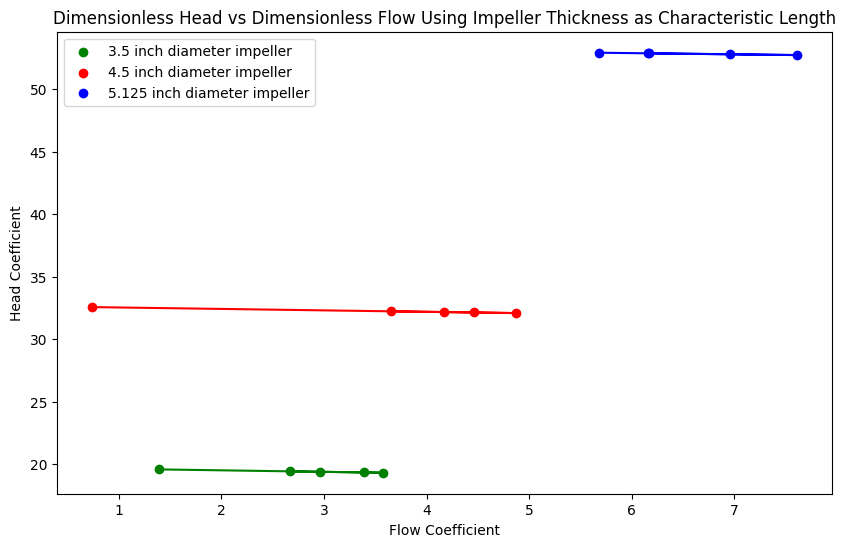

In [661]:
plt.figure(figsize=(10,6))
plt.scatter(combined_df['flow_coefficient_alt'][:5], combined_df['head_coefficient_alt'][:5], label='3.5 inch diameter impeller', color='green')
plt.scatter(combined_df['flow_coefficient_alt'][5:10], combined_df['head_coefficient_alt'][5:10], label='4.5 inch diameter impeller', color='red')
plt.scatter(combined_df['flow_coefficient_alt'][10:15], combined_df['head_coefficient_alt'][10:15], label='5.125 inch diameter impeller', color='blue')
plt.plot(combined_df['flow_coefficient_alt'][:5], combined_df['head_coefficient_alt'][:5], color='green')
plt.plot(combined_df['flow_coefficient_alt'][5:10], combined_df['head_coefficient_alt'][5:10], color='red')
plt.plot(combined_df['flow_coefficient_alt'][10:15], combined_df['head_coefficient_alt'][10:15], color='blue')

plt.title("Dimensionless Head vs Dimensionless Flow Using Impeller Thickness as Characteristic Length")
plt.xlabel("Flow Coefficient")
plt.ylabel("Head Coefficient")
plt.legend()

plt.show()

The curves for each impeller size are relatively flat, suggesting that the head coefficient does not change significantly with the flow coefficient when using impeller thickness as the characteristic length. The 5.125-inch impeller (blue) has the highest head coefficients, followed by the 4.5-inch (red) and the 3.5-inch (green) impellers. This suggests that larger impellers generate higher head coefficients when using impeller thickness as the characteristic length. Using impeller thickness as the characteristic length results in relatively flat curves, indicating that the head coefficient is less sensitive to changes in the flow coefficient.

Compared to the previous plot using impeller diameter as the characteristic length, this plot shows less variation in the head coefficient with changes in the flow coefficient. This suggests that impeller diameter might be a more appropriate characteristic length for capturing the head-flow relationship in centrifugal pumps.

## Analysis Question 6

$$ \textbf{That relationship can be rearranged to give a non-dimensional relationship between variables. What is it? }$$

To extract a dimensional relationship from our question 3 head vs flow rate plot we can extract the slope as

$$
\frac{dH}{dQ}
$$

givin units

$$
\frac{\text{meters} \ (\text{m})}{\text{cubic meters per second} \ (\text{m}^3/\text{s})}
= \frac{\text{seconds}}{\text{meters}^2} \quad \left(\frac{\text{s}}{\text{m}^2}\right)
$$

This indicates a relationship between time and area. To express this in a non-dimensional form, we use the dimensionless groups that we used for question 4

Head Coefficient (Ψ):

$$
  \Psi = \frac{H}{\omega^2 D^2}
$$

Flow Coefficient (Φ)

$$
  \Phi = \frac{Q}{\omega D^3}
$$

Differentiating \( H \) with respect to \( Q \):

$$
\frac{dH}{dQ} = \frac{d(\Psi \omega^2 D^2)}{d(\Phi \omega D^3)}
$$

Using the chain rule:

$$
\frac{dH}{dQ} = \frac{\omega^2 D^2}{\omega D^3} \frac{d\Psi}{d\Phi}
$$

Simplifying:

$$
\frac{dH}{dQ} = \frac{\omega D}{1} \frac{d\Psi}{d\Phi}
$$

Since the slope from the head-capacity graph dH/dQ is known, we solve for dPsi/dPhi:

$$
\frac{d\Psi}{d\Phi} = \frac{1}{\omega D} \left( \frac{dH}{dQ} \right)
$$

Thus, the final dimensionless relationship follows the linear form:

$$
\Psi = \Psi_0 - C \Phi
$$

where:

$$
C = \frac{1}{\omega D} \left( \frac{dH}{dQ} \right)
$$

This shows that the slope from the experimental plot directly determines the non-dimensional coefficient C, allowing us to express the pump head-flow relationship in dimensionless terms. 

**This C that we define is a new capacity variabl!e**

Our first step is to compute dH/dQ from Question 3

In [698]:
df_big = df.query("impeller_diam == 5.125")

In [699]:
h_ideals = []
qs = []
for speed in df["motor_speed"].unique():
    df_speed = df_big.query("motor_speed == @speed")
    h_ideals.append(df_speed["head_ideal"])
    qs.append(df_speed["volumetric_flowrate"])

In [700]:
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,angular_velocity_int,head_ideal,delta_head_ideal,C,drive_shaft_torque_Nm,angular_velocity_rad_s,shaft_power_W,pressure_difference_Pa,hydraulic_power_W,pump_efficiency,flow_coefficient
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,81.482441,15.422675,5.626193,112819.166844,0.5650,5.235988,2.958333,28957.980576,0.392796,0.132776,6.042216e-08
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,81.482441,9.796482,4.413457,141555.802956,0.3616,4.188790,1.514667,22752.699024,0.272739,0.180065,6.674541e-08
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,81.482441,5.383025,3.094152,190963.137173,0.2260,3.141593,0.710000,15168.466016,0.162686,0.229136,7.962610e-08
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,81.482441,2.288873,1.797174,292854.466479,0.1130,2.094395,0.236667,10342.135920,0.068511,0.289483,7.377124e-08
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,81.482441,0.491700,-24.895961,631848.176714,0.1130,1.047198,0.118333,6205.281552,0.007830,0.066168,2.810333e-08
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722,69.889965,25.387661,8.607353,92113.478277,1.1865,5.235988,6.212499,39989.592224,0.706424,0.113710,3.702392e-08
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889,69.889965,16.780308,7.513832,113301.214399,0.7910,4.188790,3.313333,32405.359216,0.531558,0.160430,4.297419e-08
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510,69.889965,9.266476,5.444231,152467.484211,0.4520,3.141593,1.420000,22752.699024,0.296663,0.208918,4.554530e-08
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793,69.889965,3.822245,3.034933,237397.036498,0.2260,2.094395,0.473333,11031.611648,0.100918,0.213207,4.793275e-08
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297,69.889965,0.787312,-33.656672,523071.617113,0.1130,1.047198,0.118333,9652.660192,0.006090,0.051464,6.611414e-09


In [701]:
qs = np.ravel(qs)
h_ideals = np.ravel(h_ideals)

In [702]:
dHdQ, intercept, _, _, _ = linregress(qs, h_ideals)

We can use this dHdQ to compute a value for our dimensionless C

In [703]:
df["C"] = (1/(df["angular_velocity_ext"] * df["impeller_diam_meters"])) * dHdQ

In [704]:
df["C"]

0      74329.812542
1      93262.666196
2     125814.208575
3     192944.321470
4     416287.035652
5      60688.070693
6      74647.404893
7     100451.721434
8     156406.732247
9     344620.655636
10     52716.153393
11     65268.728499
12     87031.385318
13    135417.641743
14    287954.017752
Name: C, dtype: float64

The term that describes the ratio of flow rate to the product of impeller volume and rotational speed is given by

$$
\frac{Q}{V_{\text{impeller}} \cdot \omega}
$$
$$
V_{\text{impeller}} \propto D^3
$$

Approximating the impeller as a cylindrical volume, its full expression is:

$$
V_{\text{impeller}} = C D^3
$$

where C is a proportionality constant related to the impeller shape. Now, we cab substitute into the required ratio:

$$
\frac{Q}{V_{\text{impeller}} \cdot \omega} = \frac{Q}{C D^3 \cdot \omega}
$$

C constant, so this ratio simplifies to:

$$
\frac{Q}{D^3 \omega}
$$

which is nothing but the dimensionless flow coefficient:

$$
\Phi = \frac{Q}{\omega D^3}
$$


$$
\Phi = \frac{Q}{\omega D^3}
$$

However, this can also be defined as:

$$
\frac{1}{\omega D} \left( \frac{dH}{dQ} \right)
$$

So this is also the same as the dimensionless variable for capacity that we compute:

$$
C = \frac{1}{\omega D} \left( \frac{dH}{dQ} \right)
$$

## Question 7
$$ \textbf{Plot dimensionless head versus capacity using this new dimensionless capacity. Again,
identify data points by impeller diameter. Does this plot give the desired relationship?}$$

In [705]:
combined_df_med = combined_df[5:10]
df_med = df.query("impeller_diam == 4.500")

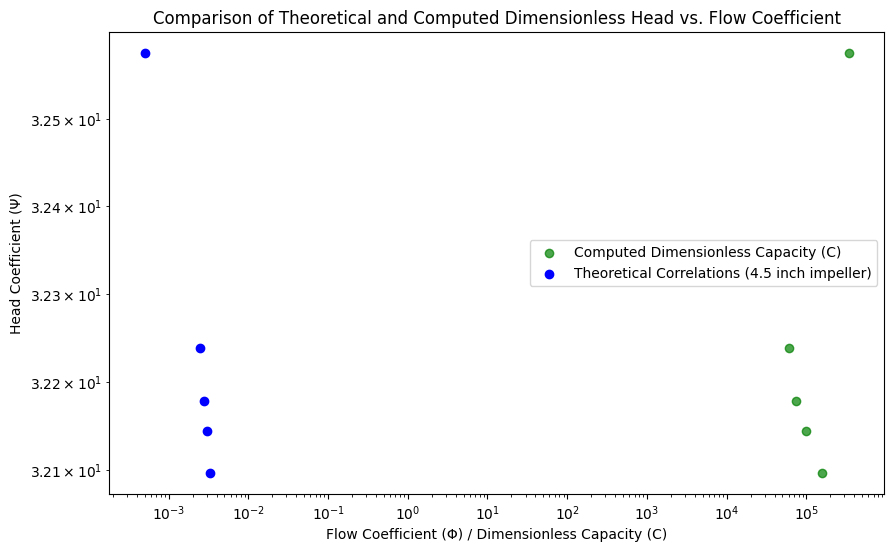

In [715]:
plt.figure(figsize=(10, 6))

plt.scatter((df_med["C"]), (combined_df_med["head_coefficient_alt"]), label="Computed Dimensionless Capacity (C)", color='green', alpha=0.7)
plt.scatter((combined_df_med['flow_coefficient']), (combined_df_med['head_coefficient_alt']), label='Theoretical Correlations (4.5 inch impeller)', color='blue')
plt.xscale('log')
plt.yscale('log')

plt.title("Comparison of Theoretical and Computed Dimensionless Head vs. Flow Coefficient")
plt.xlabel("Flow Coefficient (Φ) / Dimensionless Capacity (C)")
plt.ylabel("Head Coefficient (Ψ)")
plt.legend()

This plot does not give the desired relationship. We would expect a relationship of negative linear plots however, this shows a more exponential relationship and also has very high magnitude numbers. We can quantify the difference using a measure of R^2 to show which has a more linear fit. 

In [671]:
def compute_r_squared(df, x_col, y_col):
    X = df[[x_col]].values  # Independent variable (reshape for sklearn)
    y = combined_df_med[y_col].values  # Dependent variable
    
    model = LinearRegression()
    model.fit(X, y)
    
    r_squared = model.score(X, y)
    return r_squared

r2_value_computed = compute_r_squared(df_med, "C", "head_coefficient_alt")
r2_value_theor = compute_r_squared(combined_df_med, "head_coefficient_alt", "flow_coefficient_alt")
print(f"R² value of computed flow coefficient C: {r2_value_computed:.4f}")
print(f"R² value of theoretical flow coefficient Φ: {r2_value_theor:.4f}")


R² value of computed flow coefficient C: 0.6957
R² value of theoretical flow coefficient Φ: 1.0000


This makes it clear that the flow coefficient from theoretical correlations is much stronger than our computed correlation as given by this R^2 score. 

## Question 10

$$ \textbf{Plot pump efficiency vs volumetric flow rate for constant impeller size and rotatioal speed. Describe the shape of this curve. Explain the reason for the regions of lowest efficiency.} $$

In [672]:
pd.set_option('display.max_columns', None)  # Show all columns
df

,impeller_thickness,inner_diam,side_gap,impeller_diam,motor_speed,ext_fpm,int_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate_percentage,flow_rate,head_exp_meas,delta_head_exp_meas,volumetric_flowrate,impeller_diam_meters,inner_diam_meters,pump_suction_pressure_pa,pump_discharge_pressure_pa,head_exp,delta_head_exp,angular_velocity_ext,angular_velocity_int,head_ideal,delta_head_ideal,C
0,1.00,3.71,0.4,3.500,50.0,2907.8,778.1,139,134,280,2.2,1.3,5.5,5.0,21.5,12.9,1.8,0.2,1.356435e-05,0.088900,0.0371,110316.116480,139274.097056,2.960766,0.634450,304.504104,81.482441,15.422675,5.626193,112819.166844
1,1.00,3.71,0.4,3.500,40.0,2317.5,778.1,139,107,280,1.9,1.7,5.0,3.2,19.0,11.4,1.6,0.2,1.198710e-05,0.088900,0.0371,113074.019392,135826.718416,2.326316,0.775439,242.688032,81.482441,9.796482,4.413457,141555.802956
2,1.00,3.71,0.4,3.500,30.0,1717.9,778.1,139,81,280,1.4,2.1,4.3,2.0,17.0,10.2,1.5,0.6,1.072530e-05,0.088900,0.0371,115831.922304,131000.388320,1.550878,0.493461,179.898067,81.482441,5.383025,3.094152,190963.137173
3,1.00,3.71,0.4,3.500,20.0,1120.2,778.1,138,54,280,1.1,2.5,4.0,1.0,10.5,6.3,0.9,0.7,6.624450e-06,0.088900,0.0371,118589.825216,128931.961136,1.057416,0.422967,117.307070,81.482441,2.288873,1.797174,292854.466479
4,1.00,3.71,0.4,3.500,10.0,519.2,778.1,138,22,280,0.8,2.6,3.5,1.0,2.0,1.2,0.2,NaN,1.261800e-06,0.088900,0.0371,119279.300944,125484.582496,0.634450,-3.454227,54.370497,81.482441,0.491700,-24.895961,631848.176714
5,1.00,3.50,0.5,4.500,50.0,2770.0,667.4,140,130,300,3.6,1.0,6.8,10.5,28.0,16.8,2.4,0.2,1.766520e-05,0.114300,0.0350,108247.689296,148237.281520,4.088677,0.775439,290.073722,69.889965,25.387661,8.607353,92113.478277
6,1.00,3.50,0.5,4.500,40.0,2252.0,667.4,140,105,290,2.6,1.1,5.8,7.0,26.0,15.6,2.2,0.4,1.640340e-05,0.114300,0.0350,108937.165024,141342.524240,3.313238,0.986922,235.828889,69.889965,16.780308,7.513832,113301.214399
7,1.00,3.50,0.5,4.500,30.0,1673.5,667.4,140,80,290,1.9,1.7,5.0,4.0,20.8,12.4,1.8,0.5,1.303860e-05,0.114300,0.0350,113074.019392,135826.718416,2.326316,1.198405,175.248510,69.889965,9.266476,5.444231,152467.484211
8,1.00,3.50,0.5,4.500,20.0,1074.8,667.4,140,50,285,1.3,2.4,4.0,2.0,14.5,8.7,1.2,1.2,9.148050e-06,0.114300,0.0350,117900.349488,128931.961136,1.127911,0.140989,112.552793,69.889965,3.822245,3.034933,237397.036498
9,1.00,3.50,0.5,4.500,10.0,487.8,667.4,140,25,285,1.0,2.6,4.0,1.0,1.0,0.6,0.1,NaN,6.309000e-07,0.114300,0.0350,119279.300944,128931.961136,0.986922,-4.652633,51.082297,69.889965,0.787312,-33.656672,523071.617113


casting these columns to numerics

In [673]:
df[['motor_speed', 'drive_shaft_torque', 'volumetric_flowrate', 
    'pump_suction_pressure_pa', 'pump_discharge_pressure_pa']] = df[
    ['motor_speed', 'drive_shaft_torque', 'volumetric_flowrate', 
     'pump_suction_pressure_pa', 'pump_discharge_pressure_pa']].apply(pd.to_numeric, errors='coerce')

unit conversions for computing efficiency

In [674]:
df['drive_shaft_torque_Nm'] = df['drive_shaft_torque'] * 0.113
df['angular_velocity_rad_s'] = (2 * np.pi * df['motor_speed']) / 60
df['shaft_power_W'] = df['drive_shaft_torque_Nm'] * df['angular_velocity_rad_s']
df['pressure_difference_Pa'] = df['pump_discharge_pressure_pa'] - df['pump_suction_pressure_pa']
df['hydraulic_power_W'] = df['volumetric_flowrate'] * df['pressure_difference_Pa']
df['pump_efficiency'] = df['hydraulic_power_W'] / df['shaft_power_W']

In [675]:
# plt.figure(figsize=(12, 8))
# for (impeller, speed), subset in df.groupby(['impeller_diam', 'motor_speed']):
#     plt.plot(subset['volumetric_flowrate'], subset['pump_efficiency'],
#              marker='o', linestyle='-', label=f'Impeller {impeller}" at {speed} RPM')
    
# plt.xlabel('Volumetric Flow Rate (m³/s)')
# plt.ylabel('Pump Efficiency')
# plt.title('Pump Efficiency vs. Volumetric Flow Rate for Different Impeller Sizes and Speeds')
# plt.legend(title="Impeller & Speed", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(False)
# plt.tight_layout()
# plt.show()

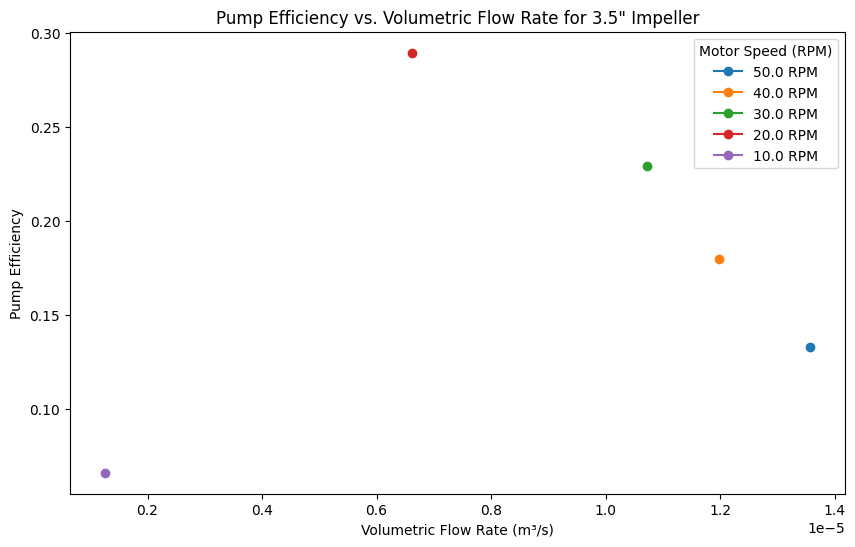

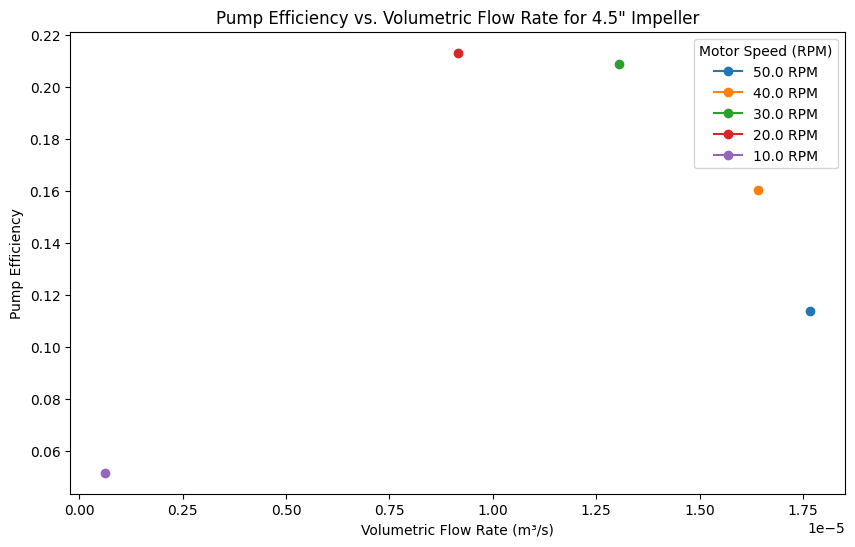

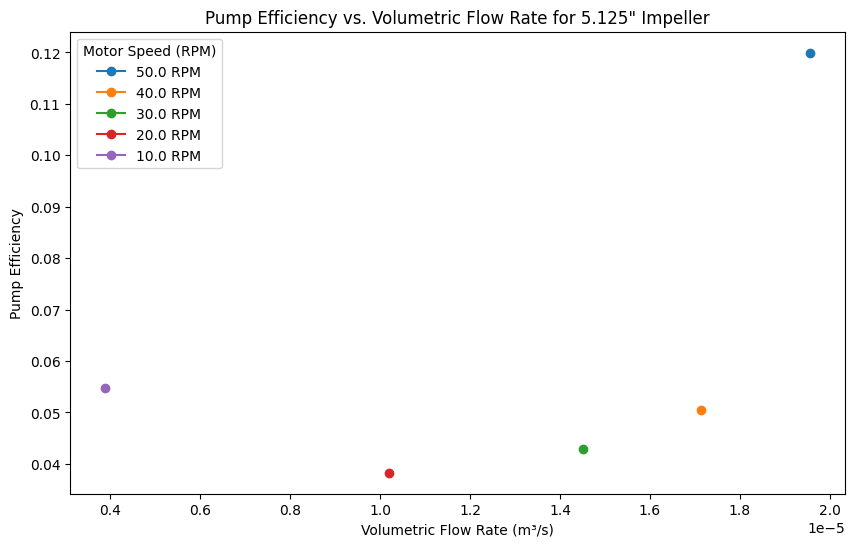

In [676]:
unique_impellers = df['impeller_diam'].unique()

for impeller in unique_impellers:
    plt.figure(figsize=(10, 6))

    df_impeller = df[df['impeller_diam'] == impeller]

    for speed in df_impeller['motor_speed'].unique():
        df_speed = df_impeller[df_impeller['motor_speed'] == speed]
        plt.plot(df_speed['volumetric_flowrate'], df_speed['pump_efficiency'], 
                 marker='o', linestyle='-', label=f'{speed} RPM')

    plt.xlabel('Volumetric Flow Rate (m³/s)')
    plt.ylabel('Pump Efficiency')
    plt.title(f'Pump Efficiency vs. Volumetric Flow Rate for {impeller}" Impeller')
    plt.legend(title="Motor Speed (RPM)")
    plt.grid(False)
    plt.show()

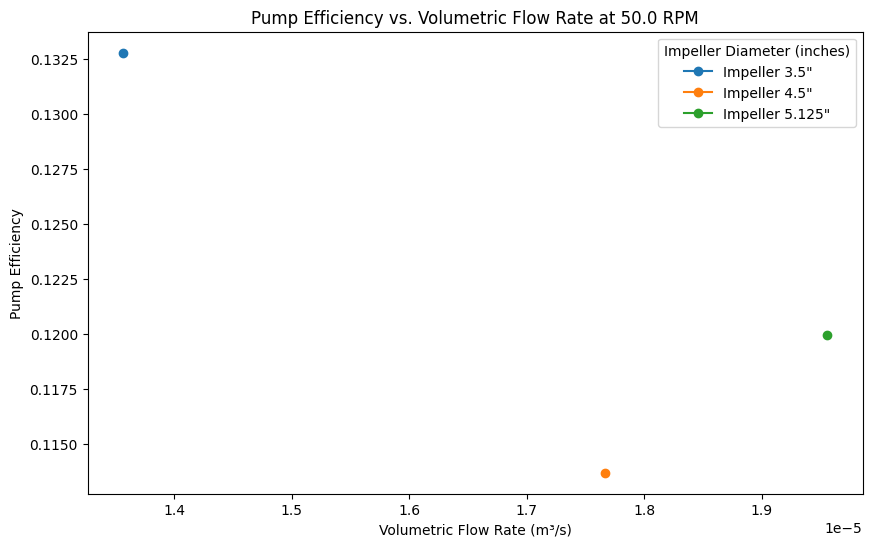

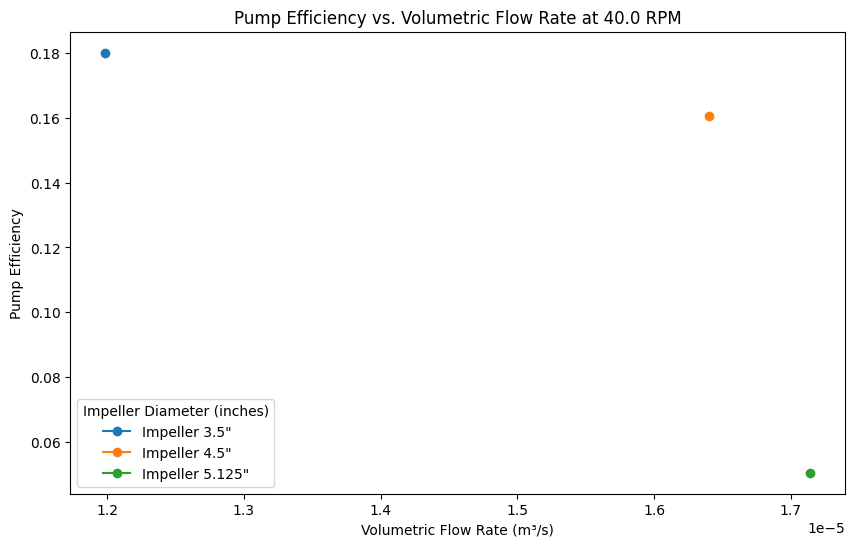

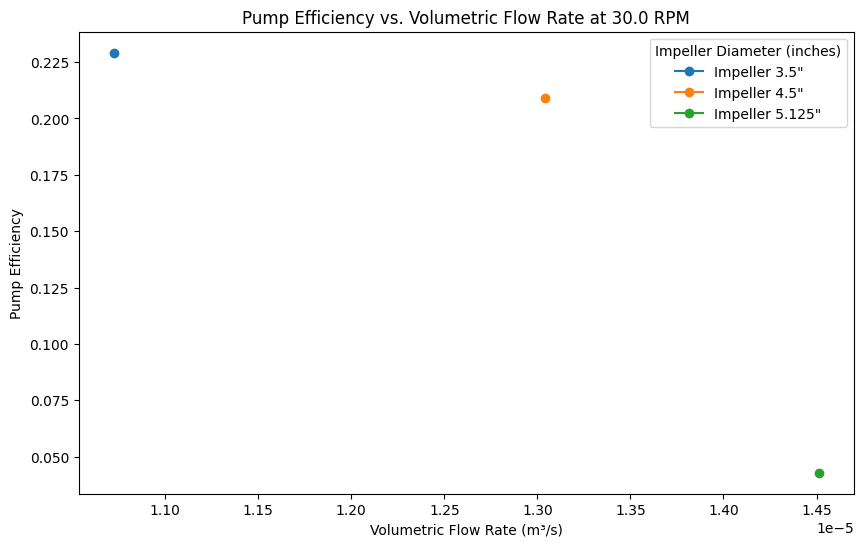

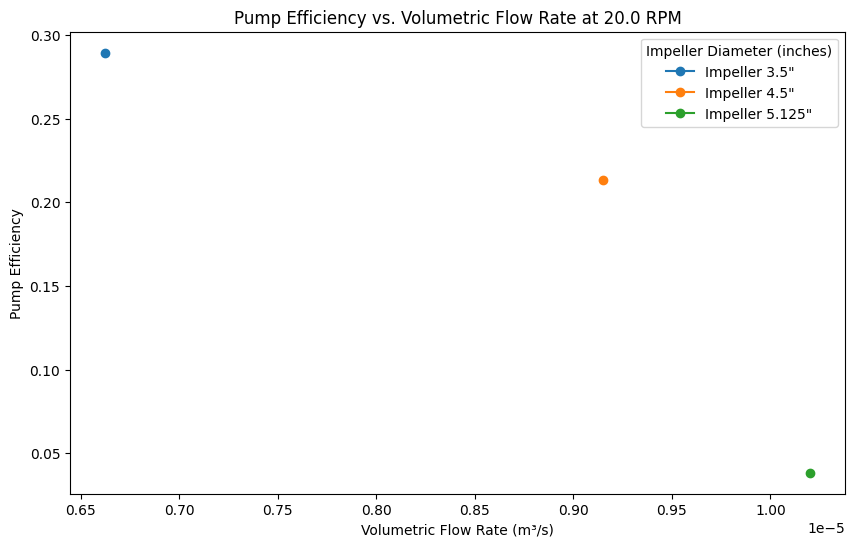

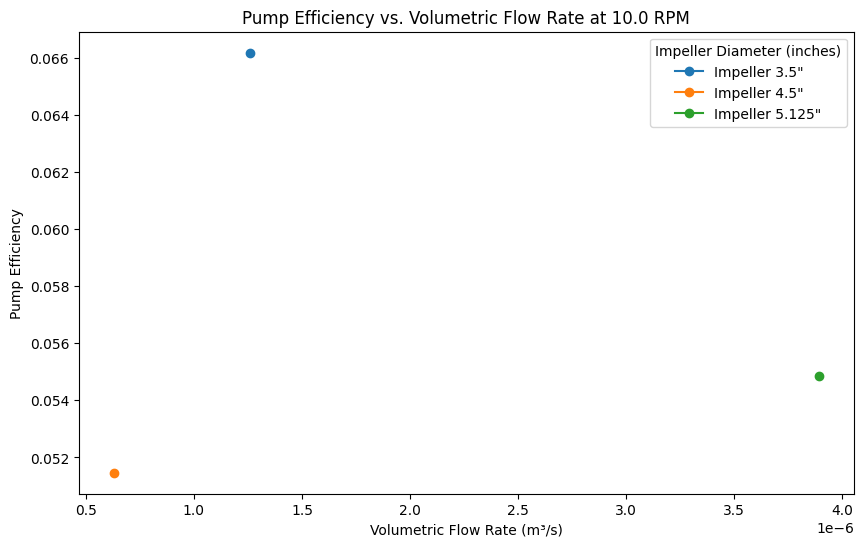

In [677]:
unique_speeds = df['motor_speed'].unique()

for speed in unique_speeds:
    plt.figure(figsize=(10, 6))

    df_speed = df[df['motor_speed'] == speed]

    for impeller in df_speed['impeller_diam'].unique():
        df_impeller = df_speed[df_speed['impeller_diam'] == impeller]
        plt.plot(df_impeller['volumetric_flowrate'], df_impeller['pump_efficiency'], 
                 marker='o', linestyle='-', label=f'Impeller {impeller}"')

    plt.xlabel('Volumetric Flow Rate (m³/s)')
    plt.ylabel('Pump Efficiency')
    plt.title(f'Pump Efficiency vs. Volumetric Flow Rate at {speed} RPM')
    plt.legend(title="Impeller Diameter (inches)")
    plt.grid(False)
    plt.show()

## Question 11

$$ \textbf{Can you describe the efficiency of the pump with a single curve and use of appropriate
dimensionless groups?} $$

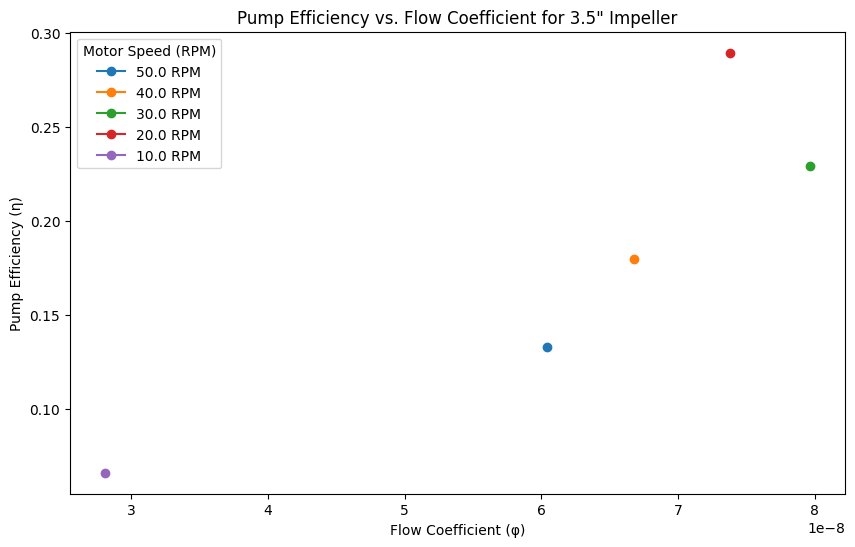

In [678]:
df['flow_coefficient'] = df['volumetric_flowrate'] / (df['angular_velocity_rad_s'] * (df['impeller_diam'] ** 3))
df_impeller = df[df['impeller_diam'] == 3.5]

plt.figure(figsize=(10, 6))
for speed in df_impeller['motor_speed'].unique():
    df_speed = df_impeller[df_impeller['motor_speed'] == speed]
    plt.plot(df_speed['flow_coefficient'], df_speed['pump_efficiency'], 
             marker='o', linestyle='-', label=f'{speed} RPM')

plt.xlabel('Flow Coefficient (φ)')
plt.ylabel('Pump Efficiency (η)')
plt.title('Pump Efficiency vs. Flow Coefficient for 3.5" Impeller')
plt.legend(title="Motor Speed (RPM)")
plt.grid(False)
plt.show()

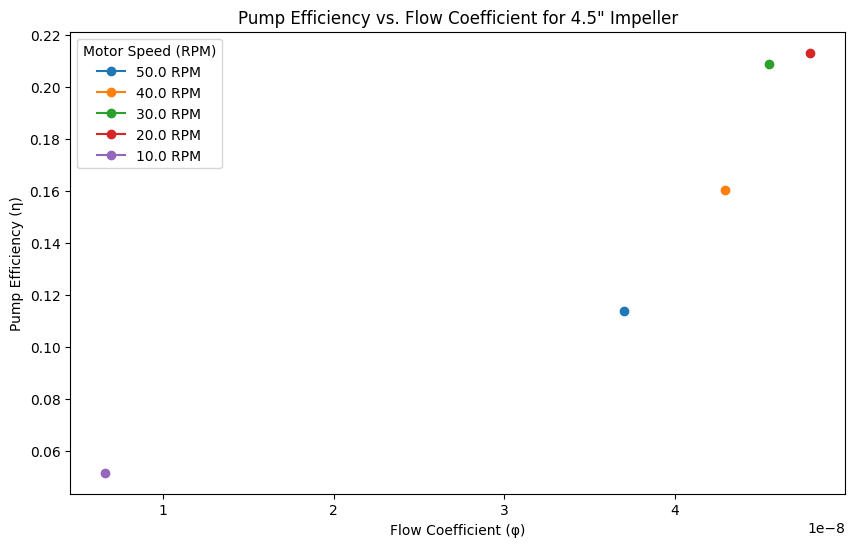

In [679]:
df_impeller = df[df['impeller_diam'] == 4.5]

plt.figure(figsize=(10, 6))
for speed in df_impeller['motor_speed'].unique():
    df_speed = df_impeller[df_impeller['motor_speed'] == speed]
    plt.plot(df_speed['flow_coefficient'], df_speed['pump_efficiency'], 
             marker='o', linestyle='-', label=f'{speed} RPM')

plt.xlabel('Flow Coefficient (φ)')
plt.ylabel('Pump Efficiency (η)')
plt.title('Pump Efficiency vs. Flow Coefficient for 4.5" Impeller')
plt.legend(title="Motor Speed (RPM)")
plt.grid(False)
plt.show()

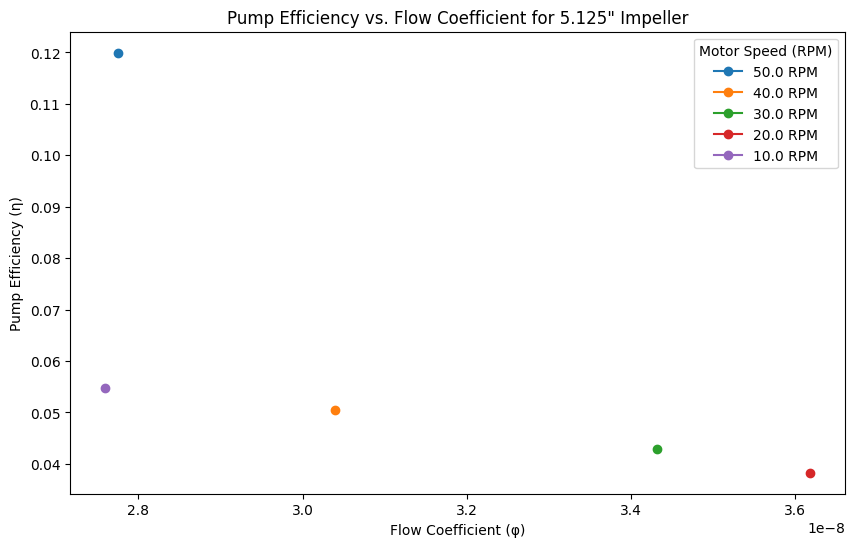

In [680]:
df_impeller = df[df['impeller_diam'] == 5.125]

plt.figure(figsize=(10, 6))
for speed in df_impeller['motor_speed'].unique():
    df_speed = df_impeller[df_impeller['motor_speed'] == speed]
    plt.plot(df_speed['flow_coefficient'], df_speed['pump_efficiency'], 
             marker='o', linestyle='-', label=f'{speed} RPM')

plt.xlabel('Flow Coefficient (φ)')
plt.ylabel('Pump Efficiency (η)')
plt.title('Pump Efficiency vs. Flow Coefficient for 5.125" Impeller')
plt.legend(title="Motor Speed (RPM)")
plt.grid(False)
plt.show()